# Exp4: 基于K-近邻的车牌号识别

## 一、案例简介

图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

## 二、作业说明

### 基本要求
* 完成数据的读入和表示，将图片表示成向量并和 label 对应上；
* 构建 K-NN 模型（可调库）对测试集中的图片进行预测并计算准确率；
* 分析当 K 取不同值时测试准确率的变化。

### 扩展要求
* 分析不同距离度量方式对模型效果的影响；
* 对比平权和加权 K-NN 的效果；
* 分析训练集大小对测试结果的影响。

## 三、数据概览
本次我们使用已经分割好的车牌图片作为数据集，包括数字 0-9、字母 A-Z（不包含 O 和 I）以及省份简称共 65 个类，编号从 0 到 64。数据已经分成了训练集和测试集，里面的文件夹用 label 编号命名，一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 20 * 20 的二值化灰度图。

下面演示一下如何借助 PIL 库将图片转化为向量：

In [1]:
from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片

In [2]:
import numpy as np
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

(20, 20)

In [3]:
pixels.flatten().reshape(1, -1).shape

(1, 400)

In [4]:
img = pixels.flatten().reshape(1, -1)

In [5]:
np.concatenate([img, img], axis=0).shape

(2, 400)

## 四、模型构建

参考文献：

* *https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier*
* *https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric*

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 数据准备

In [7]:
train_data_path = './data/train'
test_data_path = './data/test'

In [8]:
import os

def get_imgs(path):    
    """Get jpg image files."""

    for label in range(65):
        for root, dirs, files in os.walk(os.path.join(path, str(label)), topdown=False):
            for name in files:
                yield os.path.join(root, name), label

In [9]:
def get_dataset(path):
    """
    Get dataset.

    return X, y
    """
    X = None
    y = []

    for path, label in get_imgs(path):
        with Image.open(path) as f:
            img = np.array(f).flatten().reshape(1, -1)
            X = np.concatenate([X, img], axis=0) if X is not None else img
            y.append(label)


    return X, np.array(y)

训练数据&测试数据

In [10]:
%time X_train, y_train = get_dataset(train_data_path)
%time X_test, y_test = get_dataset(test_data_path)

CPU times: user 7.28 s, sys: 3.69 s, total: 11 s
Wall time: 11 s
CPU times: user 804 ms, sys: 322 ms, total: 1.13 s
Wall time: 1.15 s


In [11]:
print('Train dataset X: %s, y: %s' % (X_train.shape, y_train.shape))
print('Test  dataset X: %s, y: %s' % (X_test.shape, y_test.shape))

Train dataset X: (15854, 400), y: (15854,)
Test  dataset X: (4580, 400), y: (4580,)


训练

In [12]:
params = {
    'n_neighbors': 3,
    'weights': 'distance',
    'algorithm': 'kd_tree',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'n_jobs': 12,
}

model = KNeighborsClassifier()

model.fit(X_train, y_train)

KNeighborsClassifier()

预测

In [13]:
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7024017467248909

In [14]:
sample = np.random.randint(0, len(y_test))

print('predict: %s, label:%s' % (model.predict(X_test[sample].reshape(1, -1)), y_test[sample]))

predict: [10], label:10


In [15]:
Image.fromarray(X_test[sample].reshape(20, 20))

观察K对准确率的影响

In [16]:
k_samples = [1, 3, 5, 10, 15]
accuracies = []

for k in k_samples:
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=12)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print('KNN k:%s, accuracy: %.4f' % (k, score))

    accuracies.append(score)

KNN k:1, accuracy: 0.7227
KNN k:3, accuracy: 0.7094
KNN k:5, accuracy: 0.7024
KNN k:10, accuracy: 0.6919
KNN k:15, accuracy: 0.6806


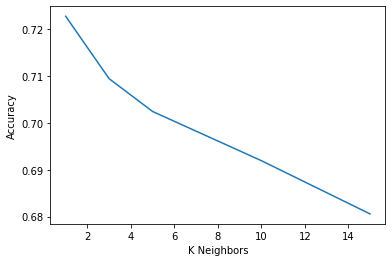

In [17]:
fig, axes = plt.subplots()
axes.plot(k_samples, accuracies)
axes.set_xlabel('K Neighbors')
_ = axes.set_ylabel('Accuracy')

In [18]:
params = {
    'n_neighbors': 3,
    'weights': 'distance',
    'algorithm': 'kd_tree',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'n_jobs': 12,
}

不同距离度量方式对模型效果的影响

In [19]:
metrics = ['minkowski', 'euclidean', 'manhattan']

for metric in metrics:
    params['metric'] = metric
    model = KNeighborsClassifier(**params)
    model.fit(X_train, y_train)
    
    score = accuracy_score(y_test, model.predict(X_test))
    print('KNN metric: %s, accuracy: %.4f' % (metric, score))

KNN metric: minkowski, accuracy: 0.7181
KNN metric: euclidean, accuracy: 0.7181
KNN metric: manhattan, accuracy: 0.7129


对比平权`uniform`和加权`weighted`对准确率的影响

In [20]:
params = {
    'n_neighbors': 3,
    'weights': 'distance',
    'algorithm': 'kd_tree',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'n_jobs': 12,
}

In [21]:
params['weights'] = 'uniform'
uniform_model = KNeighborsClassifier(**params)

uniform_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_jobs=12, n_neighbors=3)

In [22]:
params['weights'] = 'distance'
weighted_model = KNeighborsClassifier(**params)

weighted_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_jobs=12, n_neighbors=3,
                     weights='distance')

In [23]:
print('uniform  accuracy: %.6f' % (accuracy_score(y_test, uniform_model.predict(X_test))))
print('weighted accuracy: %.6f' % (accuracy_score(y_test, weighted_model.predict(X_test))))

uniform  accuracy: 0.709389
weighted accuracy: 0.718122


不同训练集大小对测试结果的影响

In [24]:
params = {
    'n_neighbors': 3,
    'weights': 'distance',
    'algorithm': 'kd_tree',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'n_jobs': 12,
}

In [25]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [27]:
ratios = np.linspace(0, 1, 10)[1:-1]
accuracy_scores = []

for ratio in ratios:
    X, _, y, _ = train_test_split(X_train, y_train, train_size=ratio, random_state=42)
    model = KNeighborsClassifier(**params)
    model.fit(X, y)

    score = accuracy_score(y_test, model.predict(X_test))
    print('KNN train dataset ratio: %.2f, accuracy: %.4f' % (ratio, score))
    accuracy_scores.append(score)

KNN train dataset ratio: 0.11, accuracy: 0.6074
KNN train dataset ratio: 0.22, accuracy: 0.6566
KNN train dataset ratio: 0.33, accuracy: 0.6659
KNN train dataset ratio: 0.44, accuracy: 0.6823
KNN train dataset ratio: 0.56, accuracy: 0.6878
KNN train dataset ratio: 0.67, accuracy: 0.6987
KNN train dataset ratio: 0.78, accuracy: 0.7098
KNN train dataset ratio: 0.89, accuracy: 0.7221


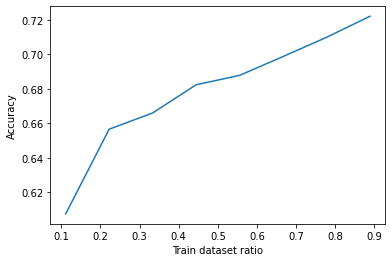

In [28]:
fig, axes = plt.subplots()
axes.plot(ratios, accuracy_scores)
axes.set_xlabel('Train dataset ratio')
_ =axes.set_ylabel('Accuracy')